In [1]:
import pandas as pd
# import altair as atl
import matplotlib.pyplot as plt
# import seaborn as sns

import re
import os

# Util Functions

In [2]:
def split(delimiters, string, maxsplit=0):
    regexPattern = '|'.join(map(re.escape, delimiters))
    return re.split(regexPattern, string, maxsplit)

# Data Collection

In [3]:
scalehls_filepath = '../results/scale_hls_summary_results.csv'

In [4]:
jobs_f_name = '../jobs-fast.sh'
with open(jobs_f_name, "r") as f:

  raw_exp_list= []
  for l in  f.readlines():
    if (not('#' in l)):
      if ('code' in l):
        raw_exp_list.append(l.strip('\n'))

  #print(raw_exp_list)

  exp_list =[]
  for e in raw_exp_list:
    r = split(['/','-',' ','.'],e)
    exp_list.append(r)

  # print(exp_list)

  paths_to_results = []
  for v in exp_list:
    tmp_path = '../'+v[0]+'/'+v[1]+'/output/'+v[1]+'_'+v[-1]+'/'+v[6]+'-'+v[8]+'-'+v[9]+'/bambu/results.txt'
    completed = os.path.exists(tmp_path)
    # print(completed, tmp_path)

    cycles=None
    if (completed):
      l = 0
      with open(tmp_path, "r") as f1:
        l=f1.readlines()[0]
        cycles = l.replace(' ',"").strip('\n').split('\t')[-1]
    
    v.append(completed)
    v.append(cycles)
    # print(v)
          
exp_list

columns =['path0',
  'kernel_name',
  'path1',
  'path2',
  'path3',
  'outline_strategy',
  'opt_strategy',
  'path4',
  'math_type',
  'has_sdcss',
  'path5',
  'k_size',
  'completed',
  'cycles']

soda_opt_df = pd.DataFrame( exp_list ,columns = columns)
drops = ['path0','path1','path2','path3','path4','path5']
for v in drops:
  soda_opt_df.drop(v, axis=1, inplace=True)

soda_opt_df['cycles']=soda_opt_df['cycles'].astype(float)
# df['k_size']=df['k_size'].astype("string")
soda_opt_df

,kernel_name,outline_strategy,opt_strategy,math_type,has_sdcss,k_size,completed,cycles
0,bicg,affine_for,opt_full,soft_float,no_ssdcs,2,True,15.0
1,bicg,affine_for,opt_full,soft_float,no_ssdcs,4,True,25.0
2,bicg,affine_for,opt_full,soft_float,no_ssdcs,8,True,49.0
3,bicg,affine_for,opt_none,soft_float,no_ssdcs,2,True,81.0
4,bicg,affine_for,opt_none,soft_float,no_ssdcs,4,True,326.0
...,...,...,...,...,...,...,...,...
79,mvt,affine_for,opt_full,soft_float,no_ssdcs,8,True,13.0
80,mvt,affine_for,opt_none,soft_float,no_ssdcs,2,True,82.0
81,mvt,affine_for,opt_none,soft_float,no_ssdcs,4,True,322.0
82,mvt,affine_for,opt_none,soft_float,no_ssdcs,8,True,1283.0


In [5]:
scale_hls_df = pd.read_csv(scalehls_filepath)
df=pd.concat([soda_opt_df,scale_hls_df])
df['cycles']=df['cycles'].astype(float)
df['k_size']=df['k_size'].astype(int)
df

,kernel_name,outline_strategy,opt_strategy,math_type,has_sdcss,k_size,completed,cycles
0,bicg,affine_for,opt_full,soft_float,no_ssdcs,2,True,15.0
1,bicg,affine_for,opt_full,soft_float,no_ssdcs,4,True,25.0
2,bicg,affine_for,opt_full,soft_float,no_ssdcs,8,True,49.0
3,bicg,affine_for,opt_none,soft_float,no_ssdcs,2,True,81.0
4,bicg,affine_for,opt_none,soft_float,no_ssdcs,4,True,326.0
...,...,...,...,...,...,...,...,...
13,syrk,affine_for,scalehls,soft_float,no_ssdcs,4,True,39.0
14,syrk,affine_for,scalehls,soft_float,no_ssdcs,8,True,74.0
15,trmm,affine_for,scalehls,soft_float,no_ssdcs,2,True,40.0
16,trmm,affine_for,scalehls,soft_float,no_ssdcs,4,True,84.0


# Data Processing

In [6]:
df_pivoted=df.pivot(index='kernel_name', columns=['k_size', 'opt_strategy'], values='cycles')
df_pivoted

k_size,2,4,8,2,4,8,16,2,4,8,16,2,4,8
opt_strategy,opt_full,opt_full,opt_full,opt_none,opt_none,opt_none,opt_none,opt_nbt,opt_nbt,opt_nbt,opt_nbt,scalehls,scalehls,scalehls
kernel_name,,,,,,,,,,,,,,
atax,25.0,42.0,NaN,84.0,331.0,1299.0,5155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bicg,15.0,25.0,49.0,81.0,326.0,1290.0,5138.0,NaN,NaN,NaN,NaN,26.0,43.0,78.0
doitgen,17.0,184.0,NaN,181.0,2742.0,43082.0,540946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gemm,18.0,32.0,NaN,111.0,858.0,7050.0,50706.0,NaN,NaN,NaN,NaN,23.0,33.0,64.0
gemver,43.0,60.0,NaN,172.0,674.0,2641.0,10659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gesummv,21.0,30.0,48.0,102.0,362.0,1362.0,5554.0,NaN,NaN,NaN,NaN,28.0,38.0,65.0
mvt,10.0,11.0,13.0,82.0,322.0,1283.0,5394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
symm,NaN,NaN,NaN,253.0,1753.0,12877.0,98837.0,17.0,19.0,NaN,NaN,NaN,NaN,NaN


In [7]:
df_pivoted=df.pivot(index='kernel_name', columns=[ 'opt_strategy', 'k_size'], values='cycles')
df_pivoted

opt_strategy opt_full                opt_none                             \
k_size             2      4       8        2       4        8         16   
kernel_name                                                                
atax             25.0   42.0     NaN     84.0   331.0   1299.0    5155.0   
bicg             15.0   25.0    49.0     81.0   326.0   1290.0    5138.0   
doitgen          17.0  184.0     NaN    181.0  2742.0  43082.0  540946.0   
gemm             18.0   32.0     NaN    111.0   858.0   7050.0   50706.0   
gemver           43.0   60.0     NaN    172.0   674.0   2641.0   10659.0   
gesummv          21.0   30.0    48.0    102.0   362.0   1362.0    5554.0   
mvt              10.0   11.0    13.0     82.0   322.0   1283.0    5394.0   
symm              NaN    NaN     NaN    253.0  1753.0  12877.0   98837.0   
syr2k            22.0  320.0  1743.0    111.0   786.0   5410.0   40002.0   
syrk             18.0  262.0  1501.0     85.0   586.0   3970.0   26946.0   
three_mm         26.0   48.0     NaN    244.0  1935.0  15578.0  123698.0   
trmm              NaN    NaN     NaN     28.0   325.0   2586.0   19570.0   
two_mm           29.0   51.0     NaN    192.0  1503.0  12242.0   96034.0   

opt_strategy opt_nbt                        scalehls               
k_size            2     4       8        16       2     4      8   
kernel_name                                                        
atax             NaN   NaN     NaN      NaN      NaN   NaN    NaN  
bicg             NaN   NaN     NaN      NaN     26.0  43.0   78.0  
doitgen          NaN   NaN     NaN      NaN      NaN   NaN    NaN  
gemm             NaN   NaN     NaN      NaN     23.0  33.0   64.0  
gemver           NaN   NaN     NaN      NaN      NaN   NaN    NaN  
gesummv          NaN   NaN     NaN      NaN     28.0  38.0   65.0  
mvt              NaN   NaN     NaN      NaN      NaN   NaN    NaN  
symm            17.0  19.0     NaN      NaN      NaN   NaN    NaN  
syr2k            NaN   NaN     NaN      NaN     35.0  47.0   81.0  
syrk             NaN   NaN     NaN      NaN     28.0  39.0   74.0  
three_mm         NaN   NaN     NaN      NaN      NaN   NaN    NaN  
trmm            13.0   NaN  2362.0  17650.0     40.0  84.0  182.0  
two_mm           NaN   NaN     NaN      NaN      NaN   NaN    NaN

In [8]:
top='opt_nbt'
bot='opt_full'
pd.merge(df_pivoted[top],df_pivoted[bot],how='left', on=[2,4,8])

k_size,2,4,8,16
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [9]:
top='opt_none'
bot='opt_full'
print("Speedup - {}/{}".format(top,bot))
tmp = (df_pivoted[top]/df_pivoted[bot]).filter([2,4,8,16])
display(tmp)
print("Mean of all values is: {:.2f}".format(tmp.stack().mean()))

Speedup - opt_none/opt_full


k_size,2,4,8,16
kernel_name,,,,
atax,3.360000,7.880952,NaN,NaN
bicg,5.400000,13.040000,26.326531,NaN
doitgen,10.647059,14.902174,NaN,NaN
gemm,6.166667,26.812500,NaN,NaN
gemver,4.000000,11.233333,NaN,NaN
gesummv,4.857143,12.066667,28.375000,NaN
mvt,8.200000,29.272727,98.692308,NaN
symm,NaN,NaN,NaN,NaN
syr2k,5.045455,2.456250,3.103844,NaN


Mean of all values is: 15.45


In [10]:
top='opt_none'
bot='opt_nbt'
print("Speedup - {}/{}".format(top,bot))
tmp = (df_pivoted[top]/df_pivoted[bot]).filter([2,4,8,16])
display(tmp)
print("Mean of all values is: {:.2f}".format(tmp.stack().mean()))

Speedup - opt_none/opt_nbt


k_size,2,4,8,16
kernel_name,,,,
atax,NaN,NaN,NaN,NaN
bicg,NaN,NaN,NaN,NaN
doitgen,NaN,NaN,NaN,NaN
gemm,NaN,NaN,NaN,NaN
gemver,NaN,NaN,NaN,NaN
gesummv,NaN,NaN,NaN,NaN
mvt,NaN,NaN,NaN,NaN
symm,14.882353,92.263158,NaN,NaN
syr2k,NaN,NaN,NaN,NaN


Mean of all values is: 22.30


In [11]:
top='scalehls'
bot='opt_full'
print("Speedup - {}/{}".format(top,bot))
tmp = (df_pivoted[top]/df_pivoted[bot]).filter([2,4,8,16])
display(tmp)
print("Mean of all values is: {:.2f}".format(tmp.stack().mean()))

Speedup - scalehls/opt_full


k_size,2,4,8
kernel_name,,,
atax,NaN,NaN,NaN
bicg,1.733333,1.720000,1.591837
doitgen,NaN,NaN,NaN
gemm,1.277778,1.031250,NaN
gemver,NaN,NaN,NaN
gesummv,1.333333,1.266667,1.354167
mvt,NaN,NaN,NaN
symm,NaN,NaN,NaN
syr2k,1.590909,0.146875,0.046472


Mean of all values is: 1.06


<AxesSubplot:xlabel='kernel_name'>

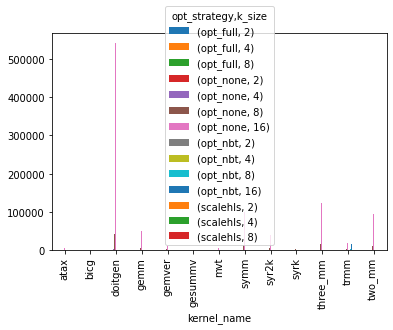

In [12]:
# df_pivoted.plot(kind='bar')

In [57]:
# df.pivot(index=['kernel_name'],columns=['opt_strategy'],values=['cycles'])
# df.columns

# df.plot(x=['kernel_name','k_size','opt_strategy'], y='cycles', kind='bar')
# df.plot(x=['kernel_name','k_size','opt_strategy'], y='cycles', kind='bar')
# df.plot(x='kernel_name', y='cycles', kind='bar')
